In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

import autoencoders

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_nrmse as nrmse

import pandas as pd
import seaborn

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
# Mnist digits dataset (download if necessary)
test_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/fashion-mnist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),                        
    download=False,
)

In [4]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [5]:
def load_autoencoder(model_name, saved_as=None, run_on="cpu"):
    
    # Set the save name to the model name if no name was specified
    if not saved_as:
        saved_as = model_name
    
    # Select what type of autoencoder to load
    used_autoencoder = getattr(autoencoders, model_name)
    autoencoder = used_autoencoder().to(run_on)

    # Load the weights from the saved file
    autoencoder.load_state_dict(torch.load("./Trained Models/" + saved_as + ".pt", ))
    
    # Set the training flag to False
    autoencoder.eval()
    
    print("Loaded:", model_name, "| In Cuda:", next(autoencoder.parameters()).is_cuda)
    return autoencoder

In [6]:
incremental_autoencoder = load_autoencoder("IncrementalAutoEncoder", run_on=device)
random_autoencoder = load_autoencoder("RandomAutoEncoder", run_on=device)
autoencoder = load_autoencoder("AutoEncoder", run_on=device)

Loaded: IncrementalAutoEncoder | In Cuda: True
Loaded: RandomAutoEncoder | In Cuda: True
Loaded: AutoEncoder | In Cuda: True


In [7]:
def autoencoder_evaluation(autoencoder, test_data, compare_function=mse, corruption_type=None, display_img=False):
    results = []
    
    test_images = test_data.data.view(-1, 28*28).type(torch.FloatTensor).to(device)/255
    
    n_images = len(test_images)
    
#     encoded_images, decoded_images = autoencoder(test_images)

    encoded_images = autoencoder.encoder(test_images)
    binary_encoded = RelaxedBernoulliStraightThrough(1, logits=encoded_images).rsample()
    
    x,y = binary_encoded.shape
    
    for k in range(0, y+1, 8):
        if corruption_type == "random" or corruption_type == "incremental":
            bit_map = np.concatenate((np.zeros((x,y-k)), np.ones((x, k))), axis=1)
            if corruption_type == "random":
                for row in bit_map: np.random.shuffle(row)
            mask = np.where(bit_map)
            
            binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]
        else:
            print("Failed to recognize the corruption type. Should be either incremental or random")
            return None

        decoded_images = autoencoder.decoder(binary_encoded)
        
        total_similarity = 0
    
        for i in range(n_images):
            test_image = test_images[i].cpu().detach().numpy()
            decoded_test_image = decoded_images[i].cpu().detach().numpy()
            if display_img and i == 999:
                displayed_image = decoded_test_image
            
            results.append({"model": autoencoder.__class__.__name__, 
                        "metric": compare_function.__name__,
                        "value": compare_function(test_image, decoded_test_image), 
                        "corruption_type": corruption_type, 
                        "corruption_percentage": k/y})
            
#             total_similarity += compare_function(test_image, decoded_test_image)

#         similarity_value = total_similarity/n_images
        
        if display_img:
            print("Model used:", autoencoder.__class__.__name__)
            print("Current corruption:", k)
            print(compare_function.__name__, ":", similarity_value)
            plt.clf()
            plt.axis('off')
            plt.imshow(np.reshape(displayed_image, (28,28)), cmap='gray')
            plt.show(); plt.pause(0.05)
            
        
#         results.append({"model": autoencoder.__class__.__name__, 
#                         "metric": compare_function.__name__,
#                         "value": similarity_value, 
#                         "corruption_type": corruption_type, 
#                         "corruption_percentage": k/y})

    return results

In [8]:
results = []

In [9]:
results += autoencoder_evaluation(incremental_autoencoder, test_data, compare_function=mse, corruption_type="incremental")
results += autoencoder_evaluation(autoencoder, test_data, compare_function=mse, corruption_type="incremental")
results += autoencoder_evaluation(random_autoencoder, test_data, compare_function=mse, corruption_type="incremental")

In [10]:
results += autoencoder_evaluation(incremental_autoencoder, test_data, compare_function=ssim, corruption_type="incremental")
results += autoencoder_evaluation(autoencoder, test_data, compare_function=ssim, corruption_type="incremental")
results += autoencoder_evaluation(random_autoencoder, test_data, compare_function=ssim, corruption_type="incremental")

In [11]:
results += autoencoder_evaluation(incremental_autoencoder, test_data, compare_function=psnr, corruption_type="incremental")
results += autoencoder_evaluation(autoencoder, test_data, compare_function=psnr, corruption_type="incremental")
results += autoencoder_evaluation(random_autoencoder, test_data, compare_function=psnr, corruption_type="incremental")

In [12]:
results += autoencoder_evaluation(incremental_autoencoder, test_data, compare_function=nrmse, corruption_type="incremental")
results += autoencoder_evaluation(autoencoder, test_data, compare_function=nrmse, corruption_type="incremental")
results += autoencoder_evaluation(random_autoencoder, test_data, compare_function=nrmse, corruption_type="incremental")

In [13]:
df = pd.DataFrame(results)

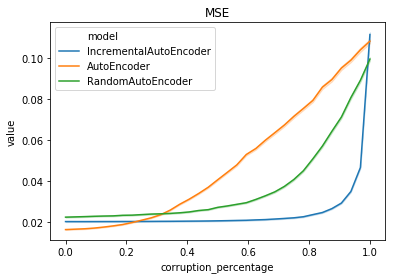

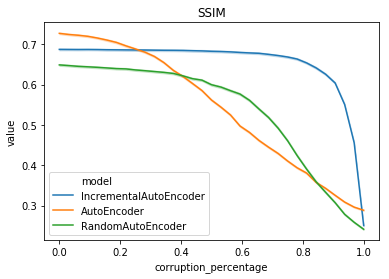

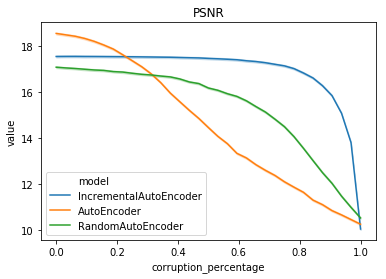

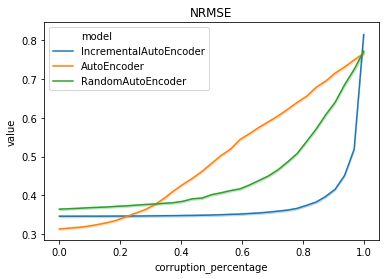

In [20]:
seaborn.lineplot(data=df[df.metric == "compare_mse"], x="corruption_percentage", y="value", hue="model").set_title("MSE")
plt.show()
seaborn.lineplot(data=df[df.metric == "compare_ssim"], x="corruption_percentage", y="value", hue="model").set_title("SSIM")
plt.show()
seaborn.lineplot(data=df[df.metric == "compare_psnr"], x="corruption_percentage", y="value", hue="model").set_title("PSNR")
plt.show()
seaborn.lineplot(data=df[df.metric == "compare_nrmse"], x="corruption_percentage", y="value", hue="model").set_title("NRMSE")
plt.show()

In [15]:
def show_test_images(autoencoder, test_data, n_test_img=5, corruption_type=None, k=0):
    view_data = test_data.data[:n_test_img].view(-1, 28*28).type(torch.FloatTensor).to(device)/255
    
    encoded_images = autoencoder.encoder(view_data)
    binary_encoded = RelaxedBernoulliStraightThrough(1, logits=encoded_images).rsample()
    
    x,y = binary_encoded.shape

    if corruption_type == "random" or corruption_type == "incremental":
        bit_map = np.concatenate((np.zeros((x,y-k)), np.ones((x, k))), axis=1)
        if corruption_type == "random":
            for row in bit_map: np.random.shuffle(row)
        mask = np.where(bit_map)
    elif k==0:
        mask = []
    else:
        print("Failed to recognize the corruption type. Should be either incremental or random")
        return None
    
    binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]

    decoded_images = autoencoder.decoder(binary_encoded)

    # initialize figure
    f, a = plt.subplots(2, n_test_img, figsize=(n_test_img, 2))

    for i in range(n_test_img):
        a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(n_test_img):
        a[1][i].clear()
        a[1][i].imshow(np.reshape(decoded_images.data.cpu().numpy()[i], (28, 28)), cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show(); plt.pause(0.05)

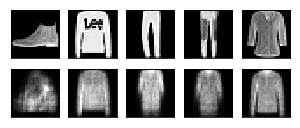

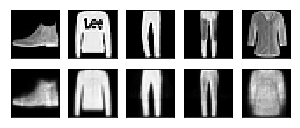

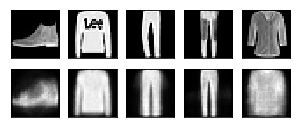

In [16]:
show_test_images(autoencoder, test_data, corruption_type="incremental", k=192)
show_test_images(incremental_autoencoder, test_data, corruption_type="incremental", k=192)
show_test_images(random_autoencoder, test_data, corruption_type="incremental", k=192)